##### Health Insurance Lead Prediction

In [295]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

In [296]:
# Loading the data and creating a copy of train and test data for further analysis

train = pd.read_csv('/content/drive/MyDrive/DS/Health Insurance Lead Prediction/train_Df64byy.csv', index_col='ID')
test = pd.read_csv('/content/drive/MyDrive/DS/Health Insurance Lead Prediction/test_YCcRUnU.csv', index_col='ID')

df_train = train.copy()
df_test = test.copy()

In [297]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50882 entries, 1 to 50882
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  object 
 1   Region_Code              50882 non-null  int64  
 2   Accomodation_Type        50882 non-null  object 
 3   Reco_Insurance_Type      50882 non-null  object 
 4   Upper_Age                50882 non-null  int64  
 5   Lower_Age                50882 non-null  int64  
 6   Is_Spouse                50882 non-null  object 
 7   Health Indicator         39191 non-null  object 
 8   Holding_Policy_Duration  30631 non-null  object 
 9   Holding_Policy_Type      30631 non-null  float64
 10  Reco_Policy_Cat          50882 non-null  int64  
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 5.4+ MB


We can see that there are 3 columns, which have NaN values.

In [298]:
# Modifying the columns that have the binary classification to appropriate numericals
# Changing the name of the column - "Health Indicator" to "Health_Indicator"
def modify_data(data):
  data = data.rename(columns={'Health Indicator': 'Health_Indicator'})
  category_cols = {"Accomodation_Type": {"Rented": 0, "Owned": 1},
                    "Reco_Insurance_Type": {"Individual": 0, "Joint": 1},
                    "Is_Spouse": {"No": 0, "Yes": 1},
                    "Health_Indicator": {"X1": 1, "X2": 2,"X3": 3, "X4": 4,"X5": 5,"X6": 6, "X7": 7,"X8": 8, "X9": 9}
                  }
  data = data.replace(category_cols)
  return data
  

In [299]:
# Applying modify_data for both train and test data
df_train = modify_data(df_train)
df_test = modify_data(df_test)

In [300]:
# Adding additional features to the data and also replacing String value to float
def new_feature(data):
  data['Age_Diff'] = data['Upper_Age']-data['Lower_Age']
  data['Holding_Policy_Duration_Check'] = np.where(data['Holding_Policy_Duration']!= '14+', 0, 1)
  data = data.replace({"Holding_Policy_Duration": {"14+": float(14)}})
  data["Holding_Policy_Duration"] = pd.to_numeric(data["Holding_Policy_Duration"], downcast="float")
  return data

In [301]:
# Applying modify_data for both train and test data
df_train = new_feature(df_train)
df_test = new_feature(df_test)

Performing EDA

In [302]:
df_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check
ID,,,,,,,,,,,,,,,
1,C3,3213,0,0,36,36,0,1.0,14.0,3.0,22,11628.0,0,0,1
2,C5,1117,1,1,75,22,0,2.0,NaN,NaN,22,30510.0,0,53,0
3,C5,3732,1,0,32,32,0,NaN,1.0,1.0,19,7450.0,1,0,0
4,C24,4378,1,1,52,48,0,1.0,14.0,3.0,19,17780.0,0,4,1
5,C8,2190,0,0,44,44,0,2.0,3.0,1.0,16,10404.0,0,0,0


In [303]:
df_train.describe()

,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check
count,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000,39191.000000,30631.000000,30631.000000,50882.000000,50882.000000,50882.000000,50882.000000,50882.000000
mean,1732.788707,0.549330,0.203333,44.856275,42.738866,0.165520,2.444694,6.015246,2.439228,15.115188,14183.950069,0.239947,2.117409,0.085197
std,1424.081652,0.497566,0.402482,17.310271,17.319375,0.371653,1.444843,4.501530,1.025923,6.340663,6590.074873,0.427055,6.865406,0.279178
min,1.000000,0.000000,0.000000,18.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2280.000000,0.000000,0.000000,0.000000
25%,523.000000,0.000000,0.000000,28.000000,27.000000,0.000000,1.000000,2.000000,1.000000,12.000000,9248.000000,0.000000,0.000000,0.000000
50%,1391.000000,1.000000,0.000000,44.000000,40.000000,0.000000,2.000000,5.000000,3.000000,17.000000,13178.000000,0.000000,0.000000,0.000000
75%,2667.000000,1.000000,0.000000,59.000000,57.000000,0.000000,3.000000,9.000000,3.000000,20.000000,18096.000000,0.000000,0.000000,0.000000
max,6194.000000,1.000000,1.000000,75.000000,75.000000,1.000000,9.000000,14.000000,4.000000,22.000000,43350.400000,1.000000,59.000000,1.000000


In [304]:
print(df_train.shape)
print(df_test.shape)

(50882, 15)
(21805, 14)


In [305]:
print(df_train['Holding_Policy_Duration'].mode())
data_pie = df_train.Holding_Policy_Duration.value_counts()
print(data_pie)

0    14.0
dtype: float32
14.0    4801
1.0     4499
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
Name: Holding_Policy_Duration, dtype: int64


In [306]:
grouped_df = df_train.groupby("City_Code")
grouped_df = grouped_df.agg({"Region_Code": "nunique"})
grouped_df = grouped_df.reset_index()
print(grouped_df)
print(grouped_df.Region_Code.sum())
print(len(df_train.Region_Code.unique()))

   City_Code  Region_Code
0         C1          741
1        C10          117
2        C11          113
3        C12           85
4        C13          102
5        C14           90
6        C15          121
7        C16          107
8        C17          125
9        C18           91
10       C19          108
11        C2          858
12       C20          115
13       C21          288
14       C22           35
15       C23           47
16       C24           88
17       C25           51
18       C26           48
19       C27           44
20       C28           55
21       C29           33
22        C3          441
23       C30            7
24       C31            9
25       C32           26
26       C33           36
27       C34           11
28       C35           13
29       C36            4
30        C4          328
31        C5          158
32        C6          179
33        C7          204
34        C8          239
35        C9          199
5316
5316


In [307]:
# Checking the percentage of NaN Values in the columns
nan_cols = ['Health_Indicator','Holding_Policy_Duration','Holding_Policy_Type']
b = df_train.shape[0]
for x in nan_cols:
  a = df_train[x].isna().sum()
  
  percent = (a/b)*100
  print(x, percent)

Health_Indicator 22.97669116780001
Holding_Policy_Duration 39.799929248064146
Holding_Policy_Type 39.799929248064146


1.0    13010
2.0    10332
3.0     6762
4.0     5743
5.0     1727
6.0     1280
7.0      196
8.0       78
9.0       63
Name: Health_Indicator, dtype: int64
14.0    4801
1.0     4499
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
Name: Holding_Policy_Duration, dtype: int64
AxesSubplot(0.260833,0.125;0.503333x0.755)
0    38673
1    12209
Name: Response, dtype: int64


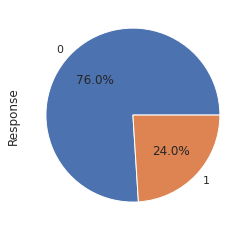

In [308]:
# Checking the value distribution of some columns
cols_for_counts = ['Health_Indicator','Holding_Policy_Duration','Holding_Policy_Type','Response']
data_pie_Health_Indicator = df_train['Health_Indicator'].value_counts()
data_pie_Policy_Duration = df_train['Holding_Policy_Duration'].value_counts()
#data_pie_Policy_Type = df_train['Holding_Policy_Type'].value_counts()
data_pie_Response = df_train['Response'].value_counts()
#print(data_pie_Health_Indicator.plot.pie(autopct="%.1f%%"))
print(data_pie_Health_Indicator)
#print(data_pie_Policy_Duration.plot.pie(autopct="%.1f%%"))
print(data_pie_Policy_Duration)
#print(data_pie_Policy_Type.plot.pie(autopct="%.1f%%"))
#print(data_pie_Policy_Type)
print(data_pie_Response.plot.pie(autopct="%.1f%%"))
print(data_pie_Response)



Text(0.5, 1.0, 'Correlation Heatmap')

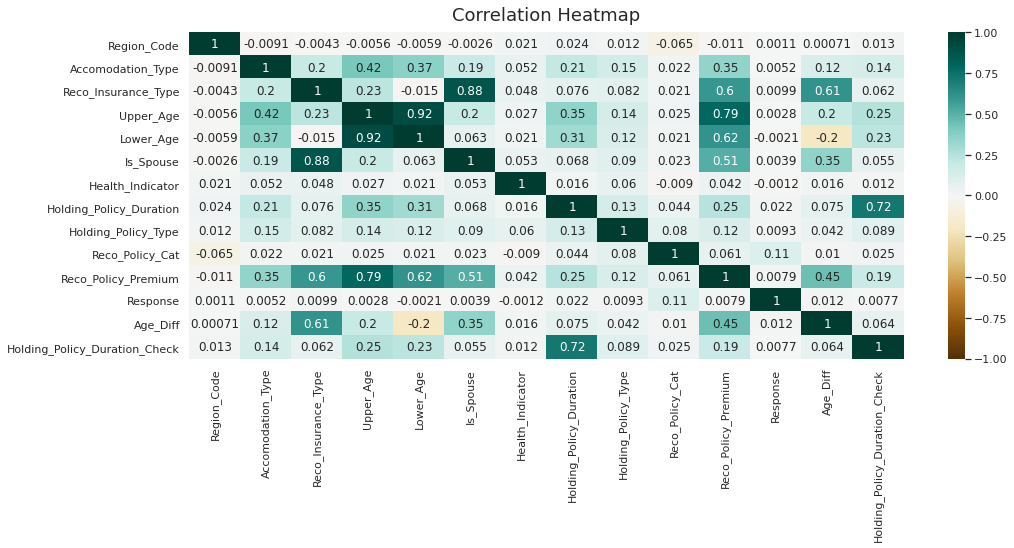

In [309]:
# Generating HeatMap of the data to check the correlation values
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [310]:
df_train.head(5)

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check
ID,,,,,,,,,,,,,,,
1,C3,3213,0,0,36,36,0,1.0,14.0,3.0,22,11628.0,0,0,1
2,C5,1117,1,1,75,22,0,2.0,NaN,NaN,22,30510.0,0,53,0
3,C5,3732,1,0,32,32,0,NaN,1.0,1.0,19,7450.0,1,0,0
4,C24,4378,1,1,52,48,0,1.0,14.0,3.0,19,17780.0,0,4,1
5,C8,2190,0,0,44,44,0,2.0,3.0,1.0,16,10404.0,0,0,0


In [311]:
# Checking the different Region Codes in both Train and Test
check_train = df_train['Region_Code'].unique()
check_test = df_test['Region_Code'].unique()
print(check_train)

count_false=0
count_true=0
for x in check_test:
  if x in check_train:
    count_true =+ 1
  else:
    count_false =+ 1

print(count_false)

[3213 1117 3732 ... 5326 6149 5450]
1


In [312]:
print(df_train.shape)
print(df_test.shape)

(50882, 15)
(21805, 14)


In [313]:
df_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check
ID,,,,,,,,,,,,,,,
1,C3,3213,0,0,36,36,0,1.0,14.0,3.0,22,11628.0,0,0,1
2,C5,1117,1,1,75,22,0,2.0,NaN,NaN,22,30510.0,0,53,0
3,C5,3732,1,0,32,32,0,NaN,1.0,1.0,19,7450.0,1,0,0
4,C24,4378,1,1,52,48,0,1.0,14.0,3.0,19,17780.0,0,4,1
5,C8,2190,0,0,44,44,0,2.0,3.0,1.0,16,10404.0,0,0,0


In [314]:
df_train[df_train['Upper_Age']>70].head(5)

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check
ID,,,,,,,,,,,,,,,
2,C5,1117,1,1,75,22,0,2.0,NaN,NaN,22,30510.0,0,53,0
8,C1,3175,1,1,75,73,1,4.0,9.0,4.0,17,29344.0,1,2,0
45,C27,811,1,0,75,75,0,1.0,NaN,NaN,20,22762.0,0,0,0
48,C4,4373,0,0,71,71,0,NaN,14.0,3.0,18,15678.0,0,0,1
50,C1,85,1,1,73,68,1,2.0,7.0,4.0,21,31692.8,0,5,0


In [315]:
corr_matrix = df_train.corr()
print(corr_matrix["Holding_Policy_Duration"].sort_values(ascending=False))
print(corr_matrix["Holding_Policy_Type"].sort_values(ascending=False))

Holding_Policy_Duration          1.000000
Holding_Policy_Duration_Check    0.720190
Upper_Age                        0.352075
Lower_Age                        0.306348
Reco_Policy_Premium              0.247903
Accomodation_Type                0.208926
Holding_Policy_Type              0.132984
Reco_Insurance_Type              0.076285
Age_Diff                         0.074715
Is_Spouse                        0.067845
Reco_Policy_Cat                  0.043925
Region_Code                      0.024317
Response                         0.021965
Health_Indicator                 0.016061
Name: Holding_Policy_Duration, dtype: float64
Holding_Policy_Type              1.000000
Accomodation_Type                0.151030
Upper_Age                        0.141890
Holding_Policy_Duration          0.132984
Reco_Policy_Premium              0.121342
Lower_Age                        0.118028
Is_Spouse                        0.090459
Holding_Policy_Duration_Check    0.088826
Reco_Insurance_Type           

Filling NaN Values

In [316]:
print(df_train.shape)
print(df_test.shape)

(50882, 15)
(21805, 14)


In [317]:
print(df_train['Health_Indicator'].mean(),df_train['Health_Indicator'].median(),df_train['Health_Indicator'].mode() )
print(df_train['Holding_Policy_Type'].mean(),df_train['Holding_Policy_Type'].median(),df_train['Holding_Policy_Type'].mode())
print(df_train['Holding_Policy_Duration'].mean(),df_train['Holding_Policy_Duration'].median(),df_train['Holding_Policy_Duration'].mode())

2.4446939348319767 2.0 0    1.0
dtype: float64
2.4392282328360158 3.0 0    3.0
dtype: float64
6.0152459144592285 5.0 0    14.0
dtype: float32


In [318]:
#Filling NaN values for the necessary columns
df_train['Health_Indicator'].fillna(round(df_train['Health_Indicator'].mean()), inplace=True)
df_train['Holding_Policy_Duration'].fillna(df_train['Holding_Policy_Duration'].median(), inplace=True)
df_train['Holding_Policy_Type'].fillna(df_train['Holding_Policy_Type'].median(), inplace=True)

df_test['Health_Indicator'].fillna(round(df_train['Health_Indicator'].mean()), inplace=True)
df_test['Holding_Policy_Duration'].fillna(df_train['Holding_Policy_Duration'].median(), inplace=True)
df_test['Holding_Policy_Type'].fillna(df_test['Holding_Policy_Type'].median(), inplace=True)

In [319]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50882 entries, 1 to 50882
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   City_Code                      50882 non-null  object 
 1   Region_Code                    50882 non-null  int64  
 2   Accomodation_Type              50882 non-null  int64  
 3   Reco_Insurance_Type            50882 non-null  int64  
 4   Upper_Age                      50882 non-null  int64  
 5   Lower_Age                      50882 non-null  int64  
 6   Is_Spouse                      50882 non-null  int64  
 7   Health_Indicator               50882 non-null  float64
 8   Holding_Policy_Duration        50882 non-null  float32
 9   Holding_Policy_Type            50882 non-null  float64
 10  Reco_Policy_Cat                50882 non-null  int64  
 11  Reco_Policy_Premium            50882 non-null  float64
 12  Response                       50882 non-null 

In [320]:
print(df_train['Holding_Policy_Duration'].unique())
print(df_train['Holding_Policy_Type'].unique())
print(df_train['Health_Indicator'].unique())

[14.  5.  1.  3.  9.  7.  2. 11. 10.  8.  6.  4. 13. 12.]
[3. 1. 4. 2.]
[1. 2. 4. 3. 6. 5. 8. 7. 9.]


In [321]:
df_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check
ID,,,,,,,,,,,,,,,
1,C3,3213,0,0,36,36,0,1.0,14.0,3.0,22,11628.0,0,0,1
2,C5,1117,1,1,75,22,0,2.0,5.0,3.0,22,30510.0,0,53,0
3,C5,3732,1,0,32,32,0,2.0,1.0,1.0,19,7450.0,1,0,0
4,C24,4378,1,1,52,48,0,1.0,14.0,3.0,19,17780.0,0,4,1
5,C8,2190,0,0,44,44,0,2.0,3.0,1.0,16,10404.0,0,0,0


One Hot Encoding for the necessary columns

In [322]:
print(len(df_train['Region_Code'].unique()))
print(len(df_test['Region_Code'].unique()))

5316
4694


In [323]:
def drop_Region(data):
  data = data.drop(['Region_Code'], axis=1)
  return data

In [324]:
df_train = drop_Region(df_train)
df_test = drop_Region(df_test)

In [325]:
cols = df_train.columns
for x in cols:
  print(len(df_train[x].unique()), x)

df_train['Health_Indicator'].unique()

36 City_Code
2 Accomodation_Type
2 Reco_Insurance_Type
58 Upper_Age
60 Lower_Age
2 Is_Spouse
9 Health_Indicator
14 Holding_Policy_Duration
4 Holding_Policy_Type
22 Reco_Policy_Cat
6977 Reco_Policy_Premium
2 Response
60 Age_Diff
2 Holding_Policy_Duration_Check


array([1., 2., 4., 3., 6., 5., 8., 7., 9.])

In [326]:
def one_hot_encoding(data):
  one_hot_cols = ['City_Code','Holding_Policy_Type','Reco_Policy_Cat']
  for x in one_hot_cols:
    one_hot = pd.get_dummies(data[x], prefix=x)
    data = data.drop(x, axis=1)
    data = data.join(one_hot)

  return data

In [327]:
print(df_train.shape)
print(df_test.shape)

(50882, 14)
(21805, 13)


In [328]:
#Applying one hot encoding for the necessary columns for both train and test data
df_train = one_hot_encoding(df_train)
df_test = one_hot_encoding(df_test)

In [329]:
print(df_train.shape)
print(df_test.shape)

(50882, 73)
(21805, 72)


In [330]:
df_train.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Holding_Policy_Type_1.0,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Reco_Policy_Cat_1,Reco_Policy_Cat_2,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9,Reco_Policy_Cat_10,Reco_Policy_Cat_11,Reco_Policy_Cat_12,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,36,36,0,1.0,14.0,11628.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1,75,22,0,2.0,5.0,30510.0,0,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,32,32,0,2.0,1.0,7450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,52,48,0,1.0,14.0,17780.0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,44,44,0,2.0,3.0,10404.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [331]:
print(df_train.shape)
print(df_test.shape)

(50882, 73)
(21805, 72)


Over Sampling

In [332]:
# Over sampling the train data to decrease the bias of Response variable
#additional_data = df_train[df_train.Response==1]
#df_train = pd.concat([df_train,additional_data])

In [333]:
df_train.shape

(50882, 73)

In [334]:
df_train.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Reco_Policy_Premium,Response,Age_Diff,Holding_Policy_Duration_Check,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Holding_Policy_Type_1.0,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Reco_Policy_Cat_1,Reco_Policy_Cat_2,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9,Reco_Policy_Cat_10,Reco_Policy_Cat_11,Reco_Policy_Cat_12,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,36,36,0,1.0,14.0,11628.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1,75,22,0,2.0,5.0,30510.0,0,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,32,32,0,2.0,1.0,7450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,52,48,0,1.0,14.0,17780.0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,44,44,0,2.0,3.0,10404.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Modeling

In [335]:
#Splitting the data
y = df_train['Response']
X = df_train.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [336]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35617, 72) (15265, 72) (35617,) (15265,)


In [337]:
df_test.shape


(21805, 72)

Applying Random Forest Classifier


In [338]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=72, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_test_pred = rf.predict(df_test)

In [339]:
# Checking the predicted roc_auc score
print(roc_auc_score(y_test, y_pred))

0.5314085636636173


In [340]:
'''forest = RandomForestClassifier(n_jobs=-1)

n_estimators = [100, 300, 500, 800]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
#min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 10)

bestF = gridF.fit(X_train, y_train)'''

'forest = RandomForestClassifier(n_jobs=-1)\n\nn_estimators = [100, 300, 500, 800]\nmax_depth = [5, 8, 15, 25, 30]\nmin_samples_split = [2, 5, 10, 15, 100]\n#min_samples_leaf = [1, 2, 5, 10] \n\nhyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  \n              min_samples_split = min_samples_split)\n\ngridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 10)\n\nbestF = gridF.fit(X_train, y_train)'

In [341]:
#gridF.best_params_

In [342]:
#{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}

In [343]:
Response_df = pd.DataFrame(y_test_pred, columns =['Response']) 


In [344]:
#Response_df['ID'] = Response_df.index
Response_df.reset_index(level=0, inplace=True)
Response_df = Response_df.rename(columns={'index': 'ID'})

In [345]:
Response_df

,ID,Response
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
21800,21800,0
21801,21801,0
21802,21802,0
21803,21803,0


In [348]:
Response_df.to_csv("/content/drive/MyDrive/Health_Insu_Lead_Prediction_Submission_V4.csv", index=False)

In [347]:
df_test.shape

(21805, 72)